# Quantum Inspire performance test

We compare performance of the simulator with the circuit from 

"Overview and Comparison of Gate Level Quantum Software Platforms", https://arxiv.org/abs/1807.02500

Pieter Eendebak <pieter.eendebak@tno.nl>

# Define the circuit

In [24]:
from IPython.display import Math
import numpy as np
import itertools
import time
import warnings
from colorama import Fore
from imp import reload
from getpass import getpass

# importing the QISKit
import qiskit
from qiskit.tools.visualization import circuit_drawer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError
from qiskit import available_backends, execute, register, get_backend, compile
from qiskit.tools.qi.qi import state_fidelity, concurrence, purity, outer
from qiskit.tools.visualization import plot_state, plot_histogram
from sympy.interactive import printing
printing.init_printing(use_latex='png')
from IPython.display import display, Math, Latex

from coreapi.auth import BasicAuthentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.utils.common import format_vector, run_circuit

We define the circuit based on the number of qubits and the depth (e.g. the number of iterations of the unit building block).

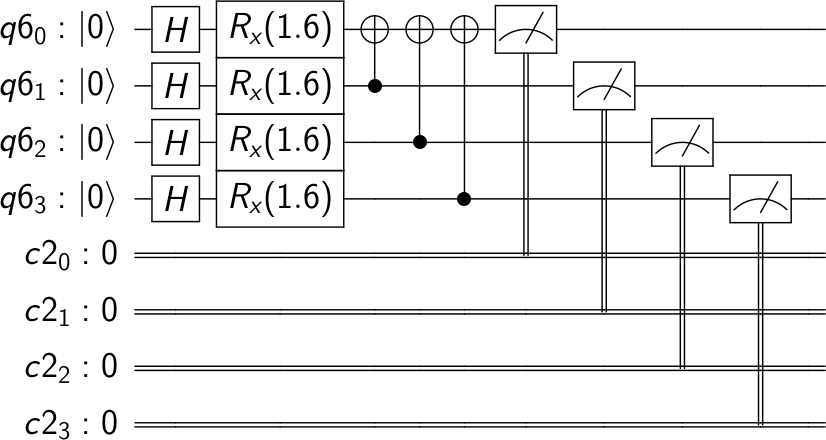

In [20]:
def pcircuit(nqubits, depth = 10):
    """ Circuit to test performance of quantum computer """
    q = QuantumRegister(nqubits)
    ans = ClassicalRegister(nqubits)
    qc = QuantumCircuit(q, ans)

    for level in range(depth):
        for qidx in range(nqubits):
            qc.h( q[qidx] )
        qc.barrier()
        for qidx in range(nqubits):
            qc.rx(np.pi/2, q[qidx])
        qc.barrier()
            
        for qidx in range(nqubits):
            if qidx!=0:
                qc.cx(q[qidx], q[0])
    for qidx in range(nqubits):
        qc.measure(q[qidx], ans[qidx])
    return q, qc

q,qc=pcircuit(4, 1)
cplot=circuit_drawer(qc)
display(cplot)

# Run the cirquit on the Quantum Inspire simulator

First we make a connection to the Quantum Inspire website.

In [21]:
try:
    passwd
except:
    print('Enter username')
    username = input();
    print('Enter password')
    passwd = getpass();

auth = BasicAuthentication(username, passwd)
qi = QuantumInspireAPI(r'https://api.quantum-inspire.com/', authentication=auth, project_name='performance_test_qi')  
_=qi.list_backend_types()

Backend: QX Single-node Simulator (qubits 26)
Backend: QX Single-node Simulator SurfSara (qubits 31)
Backend: QX Multi-node Simulator (qubits 37)
Backend: 10-Qubit NV Center (qubits 10)
Backend: 17-Qubit Transmon (qubits 17)
Backend: 2-Qubit Silicon Spin (qubits 2)
Backend: 5-Qubit Silicon Spin (qubits 5)


We create a QisKit backend for the Quantum Inspire interface and execute the circuit generated above.

In [22]:
from quantuminspire.qiskit.qiskit_backend import QiSimulatorPy
backend=QiSimulatorPy(qi_api=qi)    
j=execute(qc, backend)

run_circuit: number_of_shots 1024
generate_cqasm: 4 qubits



We can print the results and also show the cQASM that was generated.

In [9]:
print(Fore.BLUE+'Generated histogram:' + Fore.RESET)
print(j.get_counts())
print(Fore.BLUE+'Generated cQASM:' + Fore.RESET)
print(backend._cqasm[0:101] + '\n....\n' + backend._cqasm[-100:])

Generated histogram:
OrderedDict([('4', 59.0), ('15', 62.0), ('0', 54.0), ('13', 79.0), ('11', 69.0), ('3', 54.0), ('9', 74.0), ('5', 57.0), ('8', 65.0), ('10', 75.0), ('1', 60.0), ('2', 68.0), ('7', 56.0), ('6', 79.0), ('12', 52.0), ('14', 61.0)])
Generated cQASM:
version 1.0
# cqasm generated by QI backend for QisKit
qubits 4
H q[3]
H q[2]
H q[1]
H q[0]
Rz q[0], 
....
, q[0]
CNOT q[3], q[0]
.measurement
   measure q[0]
   measure q[1]
   measure q[2]
   measure q[3]



Visualization can be done with the normal Python plotting routines, or with the QisKit SDK.

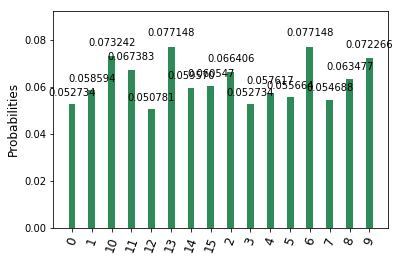

In [10]:
plot_histogram(j.get_counts(qc))

To compare we will run the circuit with 20 qubits and depth 20. This takes:

* QisKit: 3.7 seconds
* ProjectQ: 2.0 seconds

In [28]:
q,qc=pcircuit(20, 20)
t0=time.time()
j=execute(qc, backend)
dt=time.time()-t0
print('time needed: %.1f [s]' % (dt,))

run_circuit: number_of_shots 1024
generate_cqasm: 16 qubits

time needed: 213.5 [s]


## Notes

The implementation of the $sqrt(X)$ gate was done a series of $R_z$ and $R_y$ rotations.

In [8]:
# decompose U from 
#https://quantumexperience.ng.bluemix.net/qx/tutorial?sectionId=full-user-guide&page=002-The_Weird_and_Wonderful_World_of_the_Qubit~2F004-advanced_qubit_gates
I=1j
from numpy import cos, sin
import sympy as sp
from sympy import exp,pprint
from sympy.functions.elementary.trigonometric import cos,sin

theta,psi,phi,l = sp.symbols('theta psi phi lambda')

A=np.matrix([[1,0],[0,sp.exp(I*phi)]])
B=np.matrix([[cos(theta/2),-sin(theta/2)],[sin(theta/2),cos(theta/2)]])
C=np.matrix([[1,0],[0,sp.exp(I*l)]])
pprint(A*B*C)


               [[cos(theta/2) -exp(1.0*I*lambda)*sin(theta/2)]               
 [exp(1.0*I*phi)*sin(theta/2) exp(1.0*I*lambda)*exp(1.0*I*phi)*cos(theta/2)]]


In [19]:
print(j.get_counts())

OrderedDict([('4', 59.0), ('15', 62.0), ('0', 54.0), ('13', 79.0), ('11', 69.0), ('3', 54.0), ('9', 74.0), ('5', 57.0), ('8', 65.0), ('10', 75.0), ('1', 60.0), ('2', 68.0), ('7', 56.0), ('6', 79.0), ('12', 52.0), ('14', 61.0)])
